In [6]:
import rebound                                                                                                                                                           
import numpy as np                  
import matplotlib as mpl
from matplotlib import pyplot as plt    
import glob, os, re
from binary_c_API import evolve_binary

# mpl.rc('font',**{'family':'serif','serif':['Palatino']})
# mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 20

# %matplotlib inline
import warnings; warnings.simplefilter('ignore')

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

# Plot nbody output data

In [7]:
def natural_sort(l): 
    """Sorts list of filenames numerically."""
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def plot_nbody_output(main_directory, directory, filename):
    num_of_files = 0
    for file in glob.iglob(directory + '/' + '*.bin'):
        num_of_files += 1

    a_i = np.zeros(num_of_files)
    e_i = np.zeros(num_of_files)
    P_i = np.zeros(num_of_files)
    a_o = np.zeros(num_of_files)
    e_o = np.zeros(num_of_files)
    P_o = np.zeros(num_of_files)
    omega_i = np.zeros(num_of_files)
    omega_o = np.zeros(num_of_files)
    lambda_i = np.zeros(num_of_files)
    lambda_o = np.zeros(num_of_files)
    t = np.zeros(num_of_files)

    for i, file in enumerate(natural_sort(glob.glob(directory + '/' + '*.bin'))):
        sim = rebound.Simulation.from_file(file)
        orbits = sim.calculate_orbits()
        a_i[i] = orbits[0].a
        e_i[i] = orbits[0].e
        P_i[i] = orbits[0].P/(2*np.pi)
        a_o[i] = orbits[1].a
        e_o[i] = orbits[1].e
        P_o[i] = orbits[1].P/(2*np.pi)
        omega_i[i] = orbits[0].omega*180/np.pi
        omega_o[i] = orbits[1].omega*180/np.pi
        lambda_i[i] = orbits[0].l*180/np.pi
        lambda_o[i] = orbits[1].l*180/np.pi
        t[i] = sim.t/(2*np.pi)
        del sim     
        
    # Make plot
    fig, ax = plt.subplots(3, 2, figsize=(25,25))

    ax[0, 0].plot(t/1e06, a_i, 'C0.')
    ax[0, 1].plot(t/1e06, e_i, 'C1.')
    ax[0, 0].set_ylabel(r'$a_i [au]$')
    ax[0, 1].set_ylabel(r'$e_i$')

    ax[1, 0].plot(t/1e06, a_o, 'C0.')
    ax[1, 1].plot(t/1e06, e_o, 'C1.')
    ax[1, 0].set_ylabel(r'$a_o [au]$')
    ax[1, 1].set_ylabel(r'$e_o$')
    
    ax[2, 0].plot(e_o*np.cos(omega_o - omega_i),e_o*np.sin(omega_o - omega_i) , 'C0.')
    ax[2, 1].plot(t/1e06, omega_o - omega_i, 'C0.')
    ax[2, 0].set_ylabel(r'$P_o/P_i$')
    ax[2, 1].set_ylabel(r'$\omega_o - \omega_i$')

    for a in ax.ravel():
        a.set_xlabel('t [Myr]')
        a.grid(True)

    ax[1,0].set_ylim(0, 3.5)
    ax[0,1].set_ylim(0, 0.35)
    ax[1,1].set_ylim(0, 0.35)

    plt.savefig(main_directory + '/' + filename)

# Resonance crossing timescales

In [8]:
def resonance_width(m1, m2, m3, e_i, e_o, n):
    """
    Calculates the resonance width of an n-th order resonance in units of the 
    'inner binary' period. 
    """
    m123 = m1 + m2 + m3
    m12 = m1 + m2
    
    xi = np.arccosh(1/e_o) - np.sqrt(1 - e_o**2)
    width = (6*0.71**.5/((2*np.pi)**(1/4.)))*\
            (m3/m123 + n**(2/3.) *(m12/m123)**(2/3.)*(m1*m2/m12**2))**.5 *\
            (e_i**.5/e_o)*(1 - 13/24.*e_i**2.)**.5*(1 - e_o**2)**(3/8.)*\
            n**(3/4.)*np.exp(-n*xi/2.);
    return width

def select_rgb(df):
    """Slice the stellar evolution object such that it only consists of the rgb phase
    up to CE."""
    # Start when a or e drop by more than 5% from initial value
    i = 0
    while(df['a'].iloc[i] > df['a'].iloc[0]*(1 - 0.005) or\
          df['e'].iloc[i] > df['e'].iloc[0]*(1 - 0.005)):
        t0 = i
        i = i + 1
    
    # End when RLOF begins
    j = 0
    while(df['in_RLOF'].iloc[j] == 0):
        tf = j
        j = j + 1
        if not (j < len(df['t'].values) - 1):
            raise AssertionError("RLOF doesn't happen.")

    return df.iloc[t0:tf + 2]

def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map.
    credit: Jake Vanderplas.
    """
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def adiabatic_criterion(m1, m2, m3, P_i, e_i, e_o, n_res, Pdot):
    """
    Test wheater the resonance crossing is adiabatic.
    
    Given the system parameters, this function calculates the ratio between
    the librational timescale and the resonance width crossing timescale defined
    by Pdot of the binary. The calculations are based on the resonance widths 
    derived in Mardling (2013).
    
    Parameters
    ----------
    m1 : float
        Mass of the first body in msun.
    m2 : float
        Mass of the second body in msun.
    m3 : float
        Mass of the third body in msun.
    P_i : float
        Period of the 'inner binary' in days.
    e_i : float
        Eccentricity of the inner binary.
    e_o : float
        Eccentricity of the outer binary.
    n_res: int
        Resonance order.
    Pdot: float
        Time derivative of P_i in units of days/Myr
    """
    
    # Calculate resonance widths
    widths = resonance_width(m1, m2, m3, e_i, e_o, n_res)
    P_o = n_res*P_i
    nu_o = 2*np.pi/P_o # Outer mean motion
    omega_n = nu_o*widths/2 # Libration frequency
    lib_period = 2*np.pi/omega_n # Libration period
            
    crossing_time = 2*widths*P_i/Pdot
    
    timescale_ratio = np.abs(lib_period/(crossing_time*1e06))
    
    return timescale_ratio

def plot_timescale_ratio(m1, q, m3, P_i, e_i, n_res):

    fig, ax = plt.subplots(figsize=(10,8))

    # Evolve binary, select only RGB phase
    data = select_rgb(evolve_binary(13700, m1, q*m1, 0.02, P_i, e_i))

    t = data['t'].values # Myr
    
    e_o = np.linspace(0.0, 0.2, len(t))

    X, Y = np.meshgrid(t, e_o)
    Pdot = np.zeros((len(t), len(t)))

    for e in range(0, len(t) -1):
        Pdot[e, :-1]  = np.diff(data['P'].values)/np.diff(X[e, :]) # days/Myr

    timescale_ratio = adiabatic_criterion(m1, m1*q, m3, data['P'].values, data['e'].values,
                                          Y, n_res, Pdot)
    del data
    
    colors='PuBu'
    pcolor = ax.pcolormesh(X, Y, timescale_ratio, norm=mpl.colors.LogNorm(
        vmin=1e-03, vmax=1e03), cmap=discrete_cmap(6, colors))
    cbar = plt.colorbar(pcolor, label=r'$\log(P_{lib}/t_{cross})$')

    ax.set_xlabel(r"t [Myr]")
    ax.set_ylabel(r"$e_o$")
    ax.set_title("{:d}:1 resonance".format(n_res))
    
#     plt.savefig(main_directory + 'timescale_ratio.pdf')

In [9]:
# Iterate over all folders with nbody output, make plots and save them
M1 = np.array([1.2, 1.6, 2.0])
q = [0.3, 0.6, 0.8]
P = [20, 200]
e = [0., 0.1, 0.3]

from itertools import product
for M1_, q_, P_, e_ in product(M1, q, P, e):
    main_directory = 'nbody_sims/' + str(M1_) + '_' + str(q_) + '_'\
        + str(P_) + '_' + str(e_) 
    
    if(e_ > 0.1):
        directory = main_directory + '/' + '1.00_6.90'
        directory_dense = main_directory + '/' + '1.00_6.80_dense'
        n_res = 7
    else:
        directory = main_directory + '/' + '1.00_5.90'
        directory_dense = main_directory + '/' + '1.00_5.80_dense'
        n_res = 6
        
    if not os.path.exists(directory):
        os.makedirs(directory)
    if not os.path.exists(directory_dense):
        os.makedirs(directory_dense)
    
    plot_nbody_output(main_directory, directory, 'plot.png')
    plot_nbody_output(main_directory, directory_dense, 'plot_dense.png')

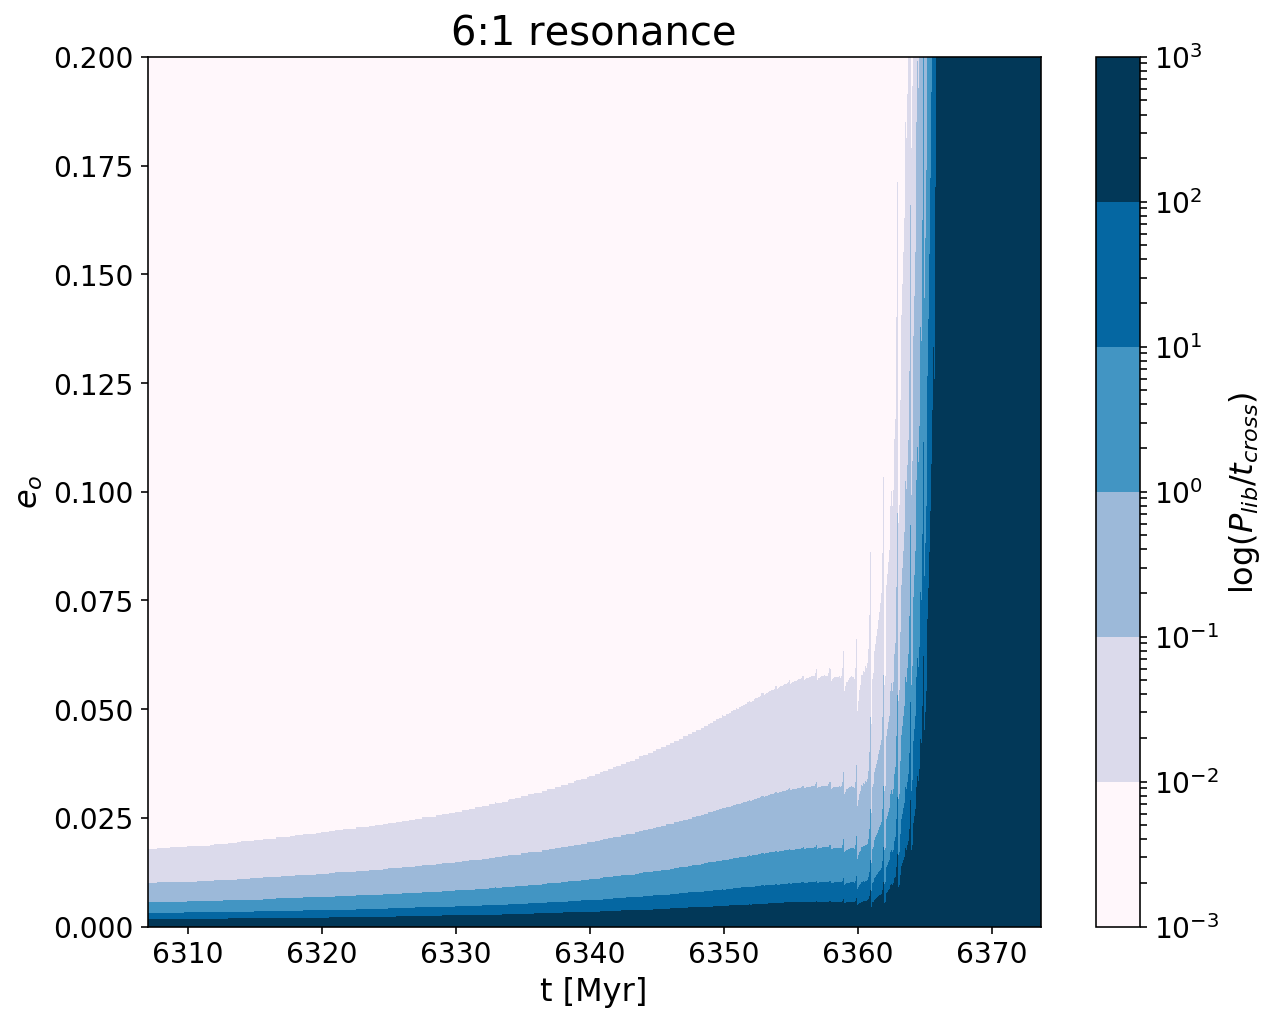

In [10]:
%matplotlib inline
plot_timescale_ratio(1.2, 0.6, 0.0009543, 200, 0.3, 6)

In [11]:
# plt.plot (t/1e06, (lambda_i - 6.*lambda_o - omega_i - 4*omega_o) , 'C0.')